## **Análise Exploratória e Pré-processamento dos Dados**
Aqui serão realizadas análises preliminares dos dados, como estatísticas, decomposição para análise de tendência, sazonalidade e resíduo das séries. Posteriormente, os dados serão separados em treino e teste para as próximas etapas do projeto: **_engenharia de características_**, **_modelagem_** e **_comparação dos resultados_**.

In [1]:
# preparação do notebook
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
from utilsforecast.preprocessing import fill_gaps
from src.features import decompose
from src.plots import plot_time_series, plot_time_series_acf
from src.utils import ts_train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings('ignore')

# configuração de estilo
sns.set_theme(context='paper')
plt.rcParams["figure.dpi"] = 150


%load_ext autoreload
%autoreload 2

In [2]:
# leitura dos dados brutos
df = pd.read_csv(
    "data/data.csv",
    sep=';', 
    parse_dates=['ds'],
    dayfirst=True,
    dtype={'y': np.int32}
)

**NOTA:** Um passo muito importante para trabalhar com séries temporais é garantir que os dados tenham continuidade na frequência de captura das informações. Nos dados do projeto, a frequência de armazenamento é diária, logo, precisamos garantir que todos os dias situados entre **$t_0$** e **$t_n$** estejam presentes, mesmo que não tenha sido captado nenhum dado para alguns períodos. \
Por exemplo: Em dias que nenhuma venda é registrada para algum produto, alguns bancos de dados não tratão a unidade amostral correspondente para aquele dia, mas para fins de modelagem, esse dia deve estar registrado com zero, pois é um evento de interesse.

In [3]:
# preenchendo os dados com os dias ausentes
df = fill_gaps(
    df=df,
    freq='D',
    start='per_serie',
    end='per_serie'
).fillna(0)

In [4]:
# estatísticas descritivas
df.groupby("unique_id")['y'].describe()

,count,mean,std,min,25%,50%,75%,max
unique_id,,,,,,,,
SKU_01,1696.00,169.23,156.41,0.00,28.00,114.50,298.00,752.00
SKU_02,2088.00,271.55,205.25,0.00,66.00,265.00,431.00,1350.00
SKU_03,2087.00,61.27,48.56,0.00,15.00,53.00,102.00,242.00
SKU_04,2088.00,47.15,35.64,0.00,11.00,51.00,75.00,406.00
SKU_05,2087.00,399.31,359.03,0.00,67.50,357.00,605.00,1850.00
SKU_06,2087.00,40.24,35.62,0.00,8.00,37.00,61.00,381.00
SKU_07,2088.00,675.27,1118.08,0.00,127.75,590.00,1011.25,40252.00
SKU_08,2088.00,76.23,61.00,0.00,17.00,75.00,122.00,478.00
SKU_09,2087.00,79.84,70.98,0.00,13.00,81.00,116.00,1008.00


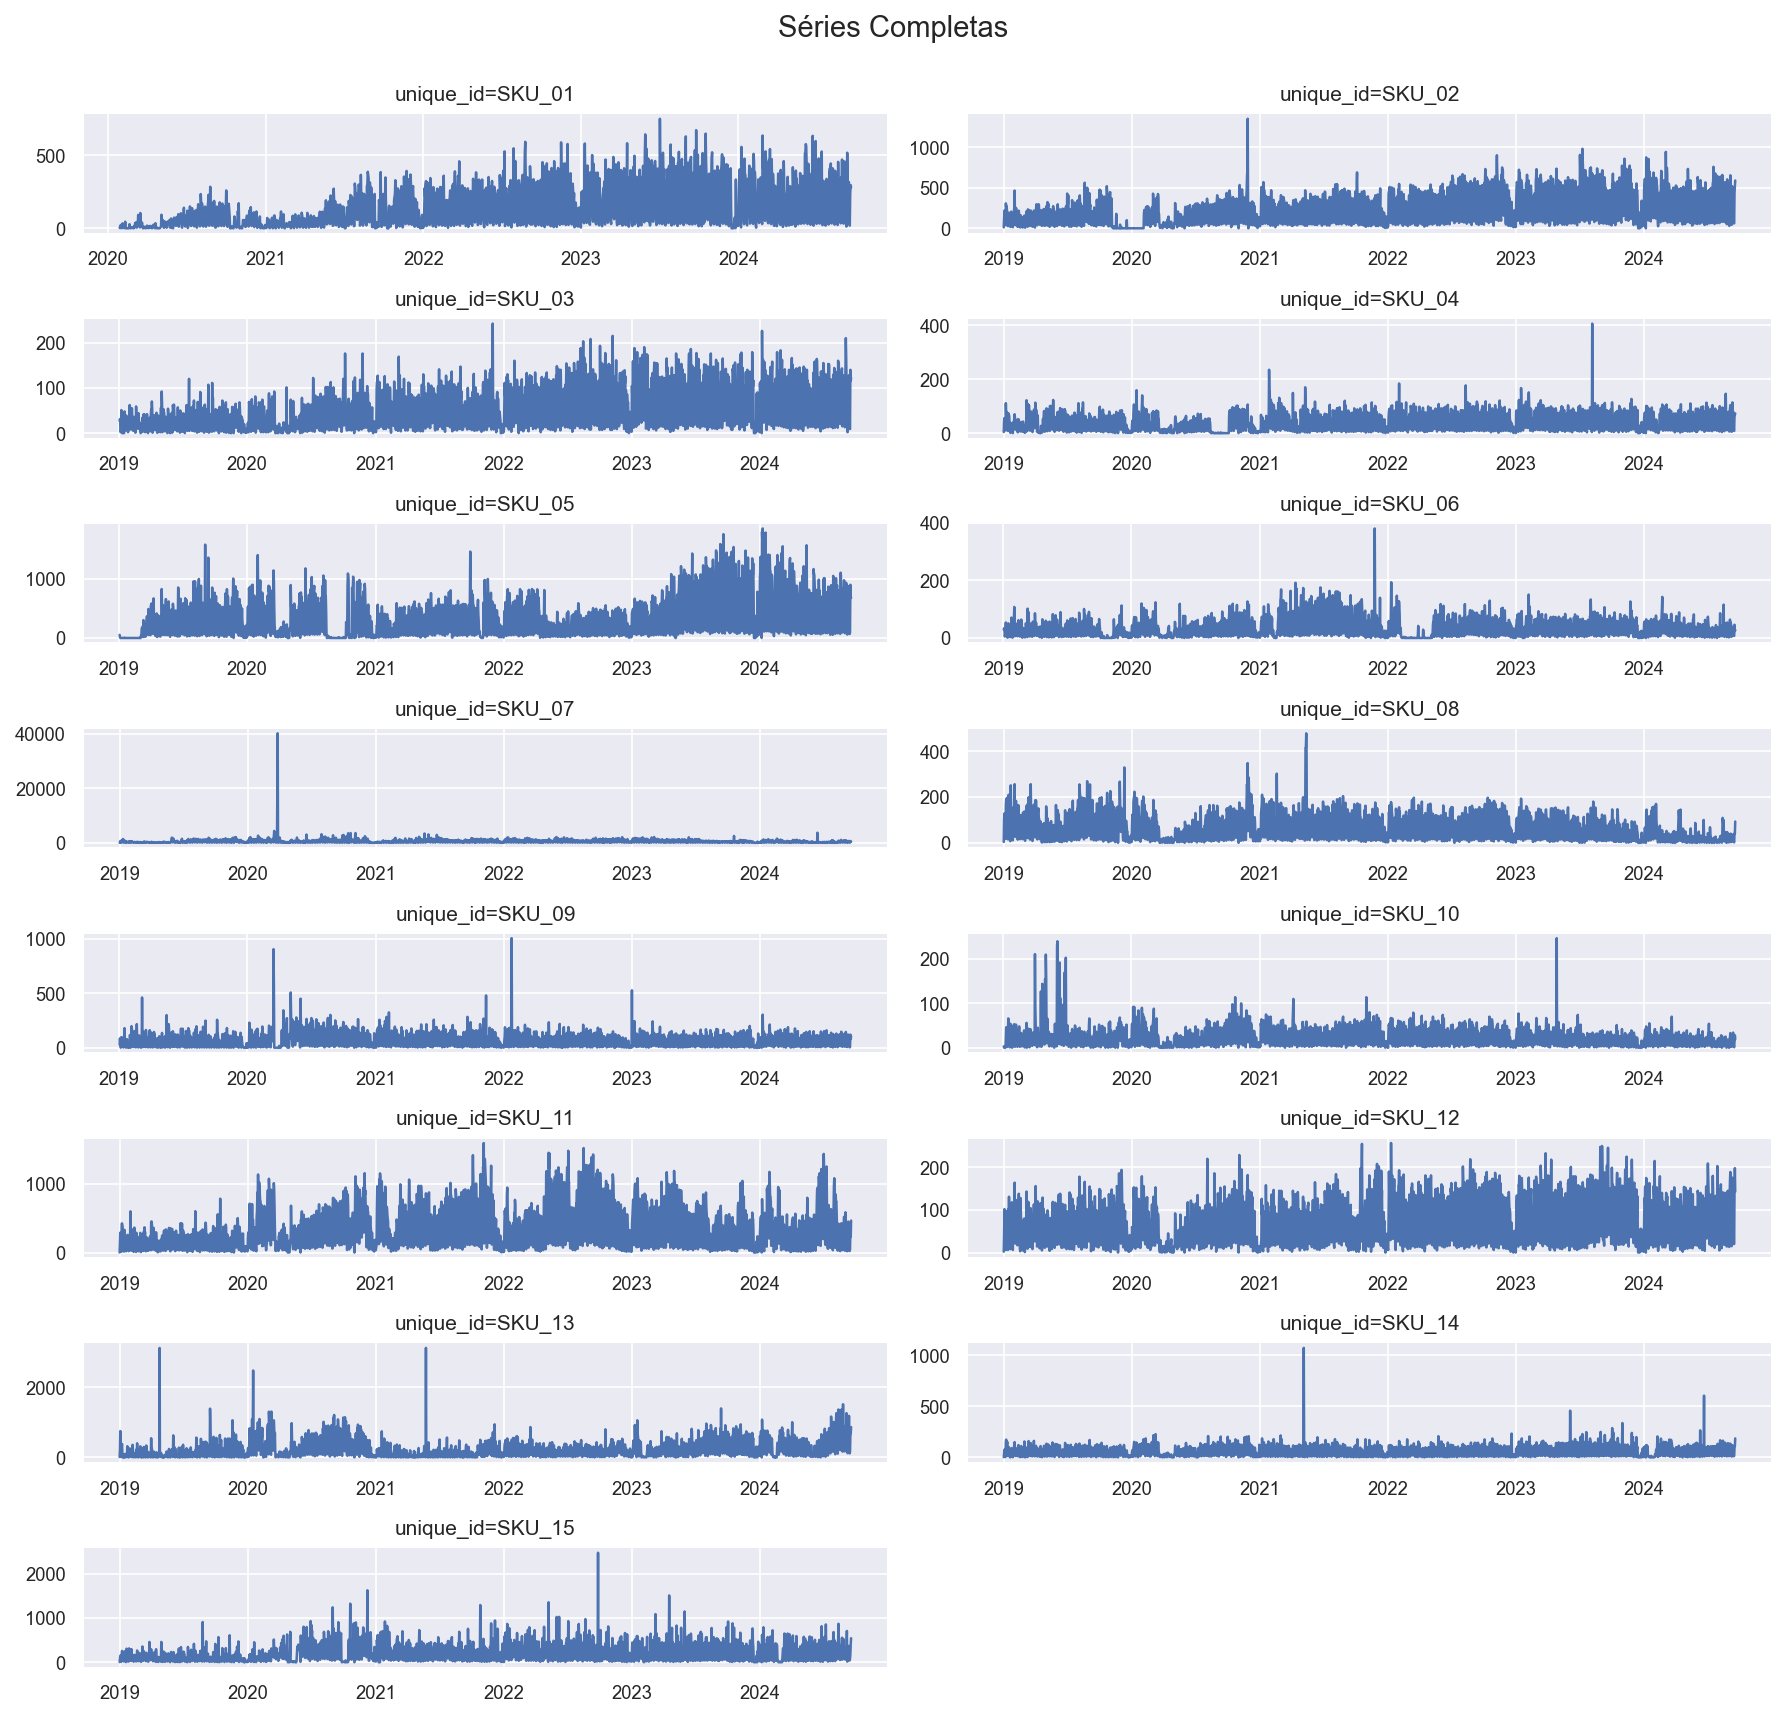

In [5]:
# plot das séries temporais completas
fig1 = plot_time_series(
    df=df,
    data_cols=['y'],
    figsize=(12, 12),
    title='Séries Completas'
)

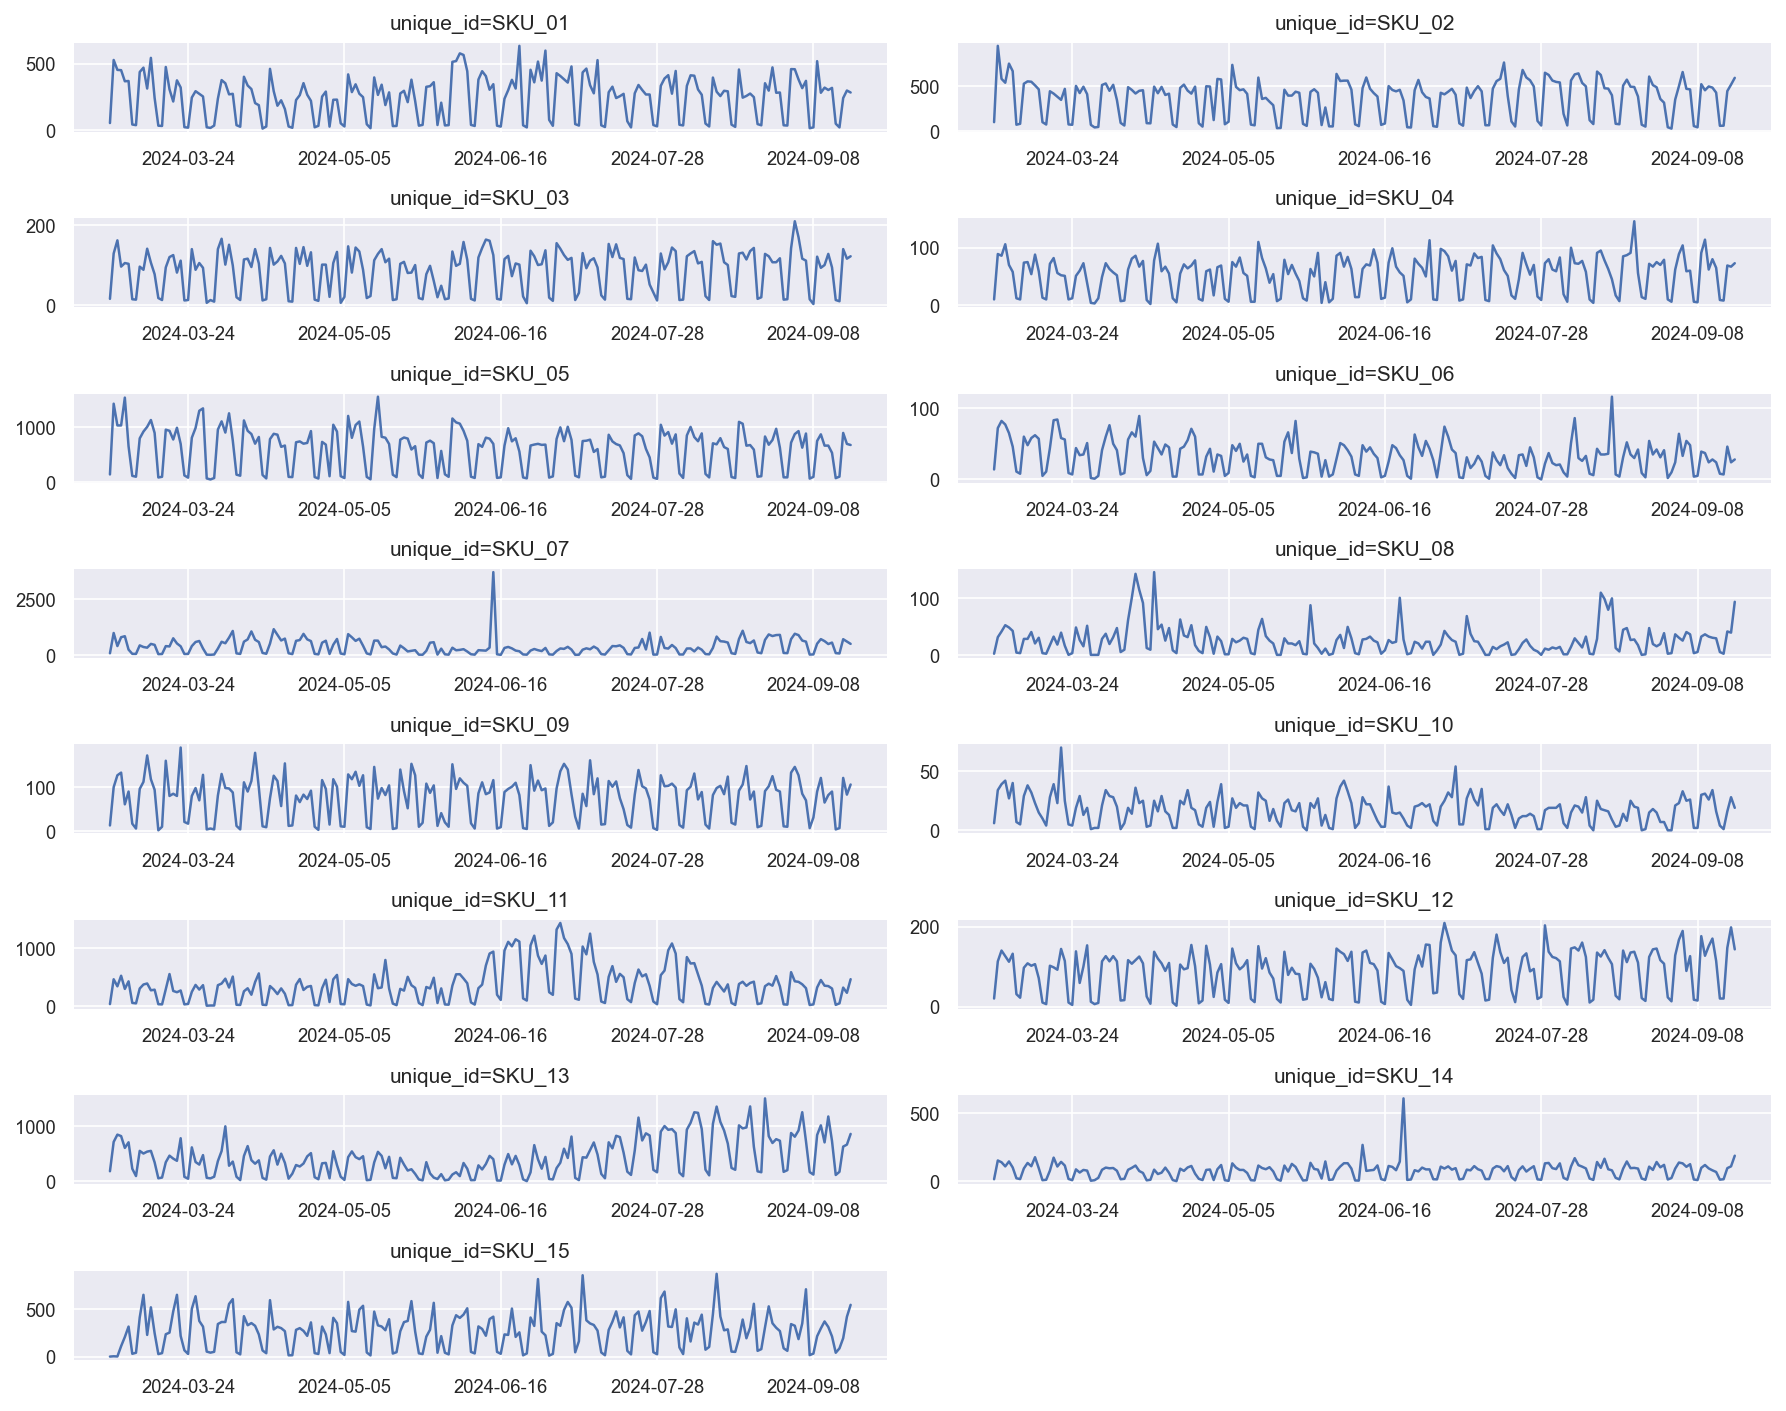

In [6]:
# plot os últimos 200 registros de cada série temporal
fig2 = plot_time_series(
    df=df,
    data_cols=['y'],
    grid=(8, 2),
    figsize=(12, 10),
    n_max=200
)

In [7]:
# decompondo as séries
decomposed_df = decompose(df)

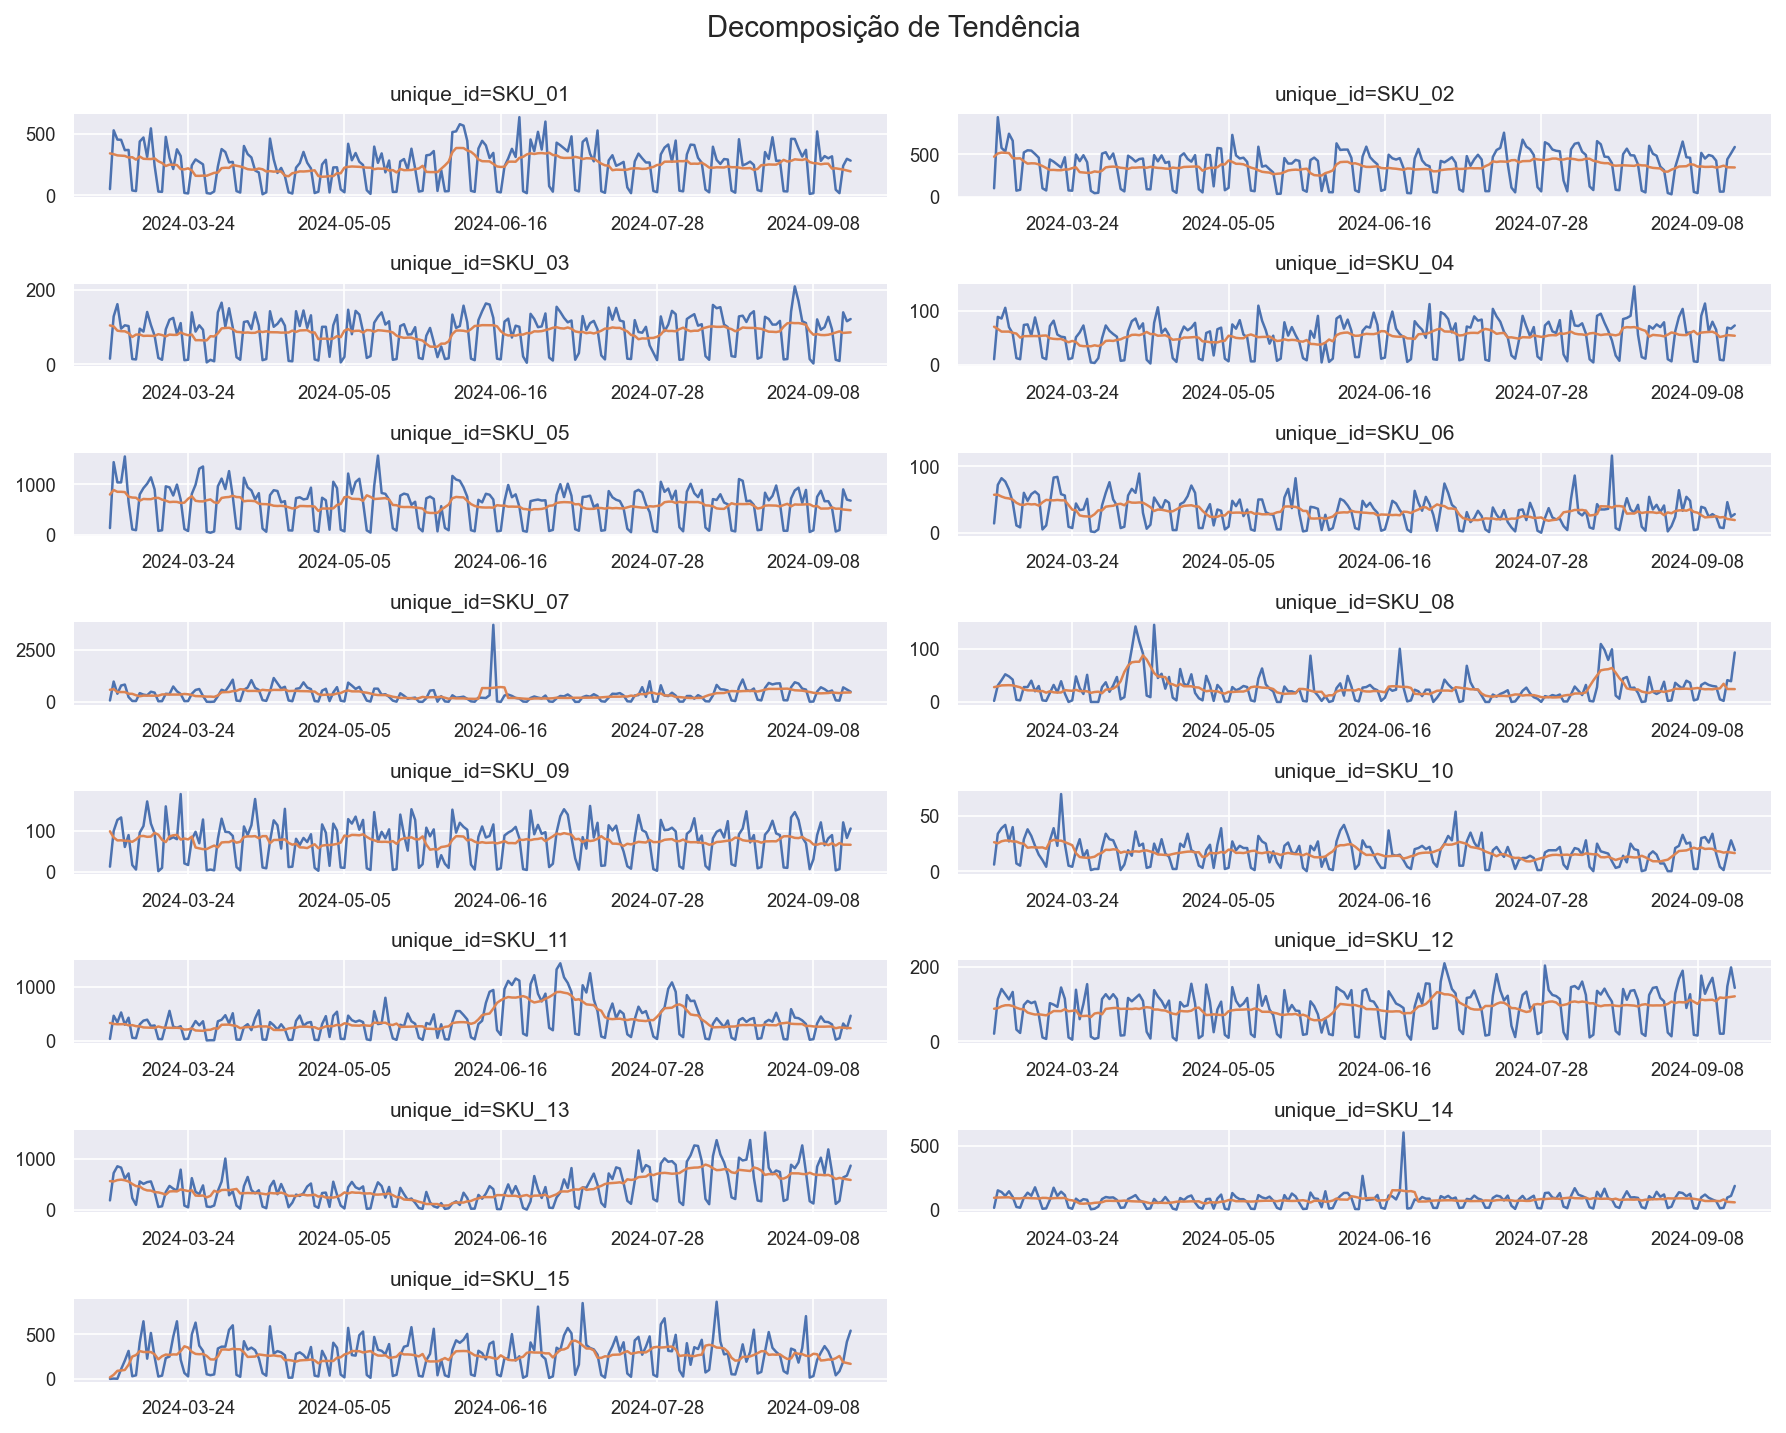

In [8]:
# plot das séries com a tendência baseada em média móvel
fig3 = plot_time_series(
    df=decomposed_df,
    data_cols=['y', 'trend'],
    figsize=(12, 10),
    n_max=200,
    title='Decomposição de Tendência'
)

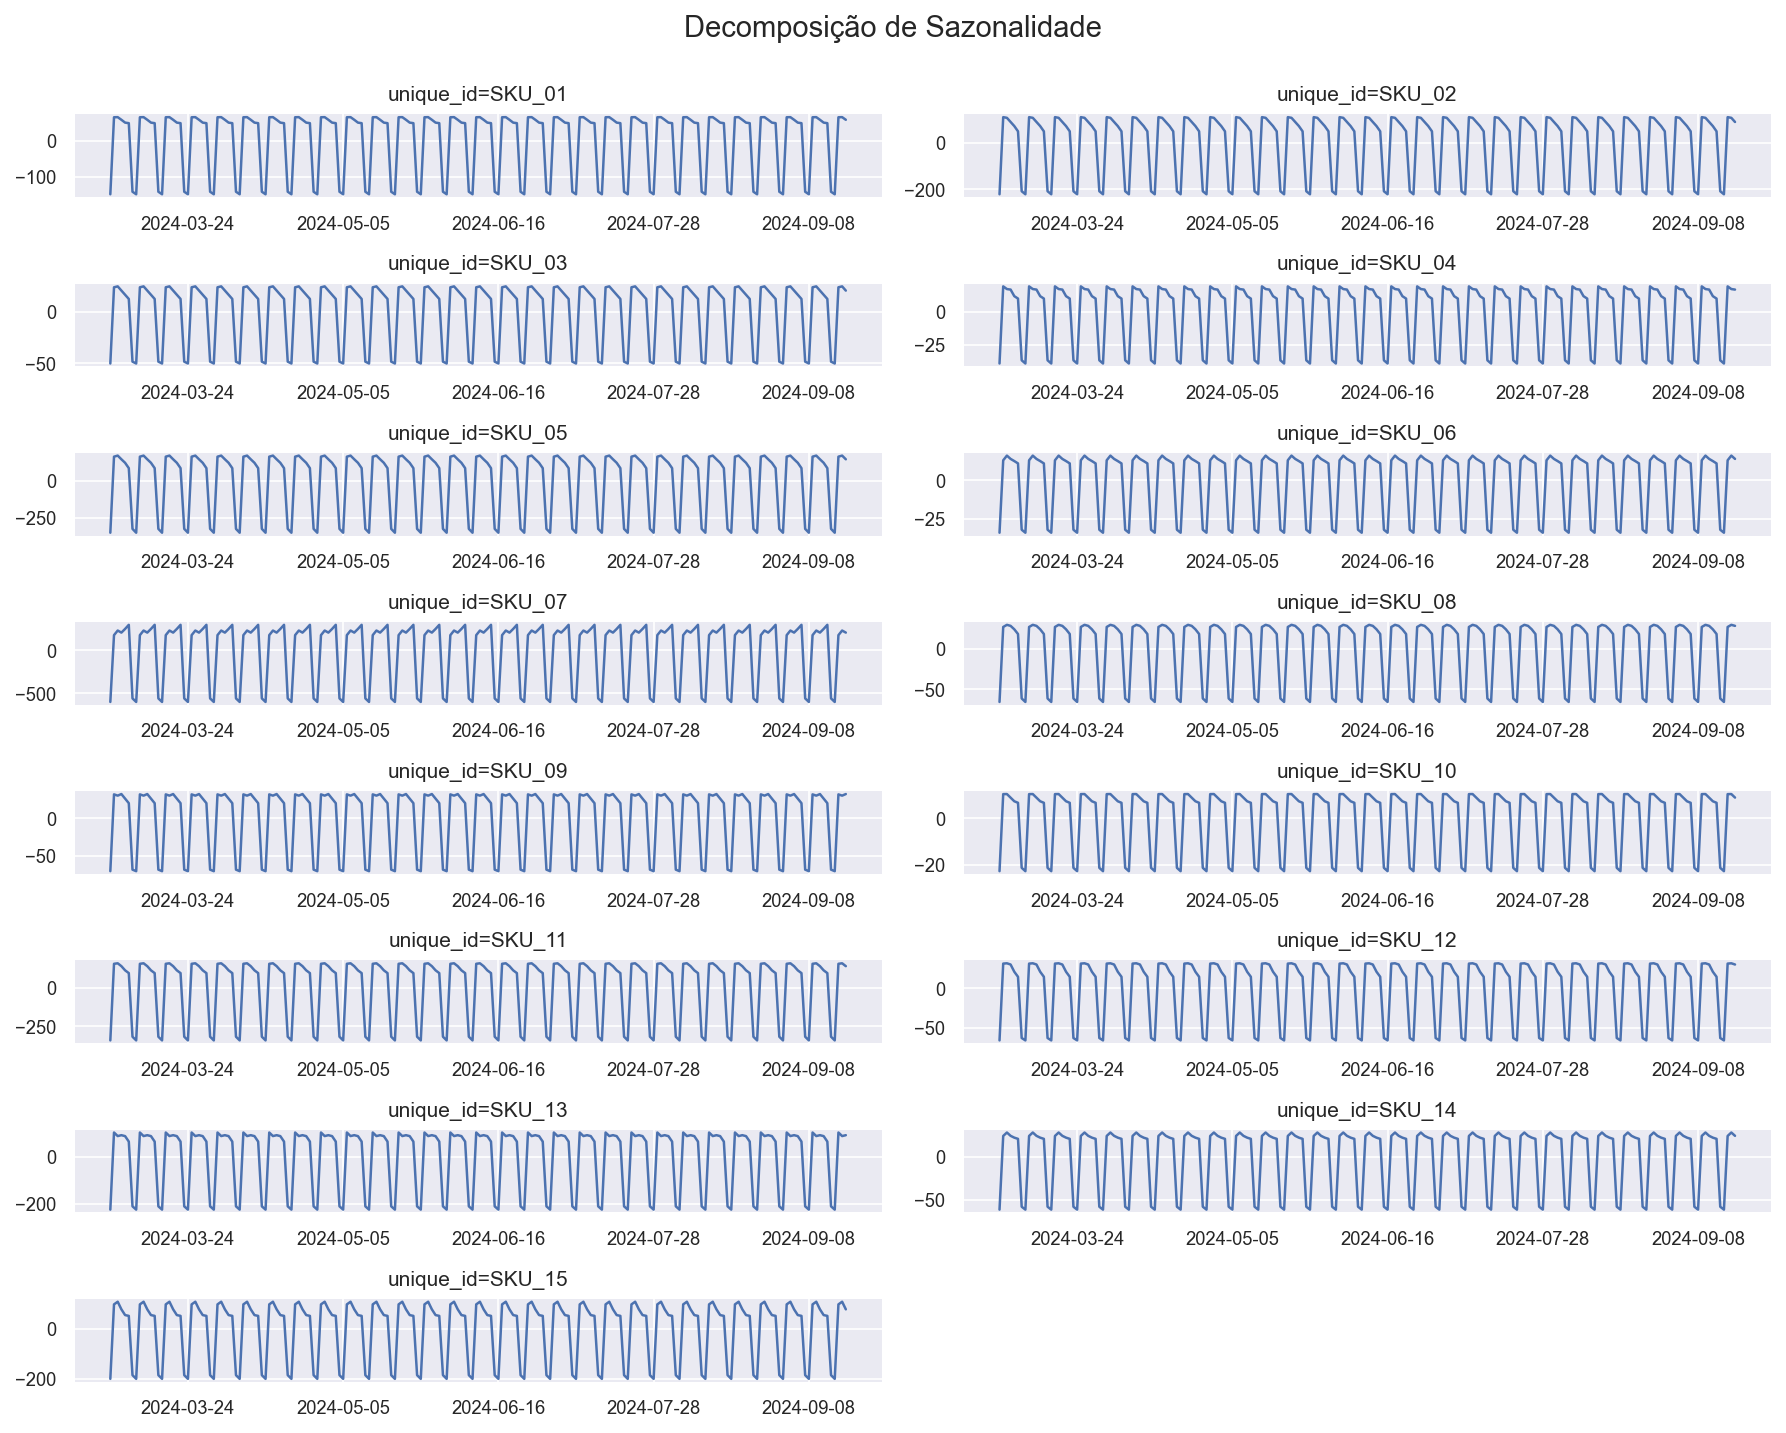

In [9]:
# plot do termo sazonal da série
fig4 = plot_time_series(
    decomposed_df,
    data_cols=['seasonal'],
    figsize=(12, 10),
    n_max=200,
    title='Decomposição de Sazonalidade'
)

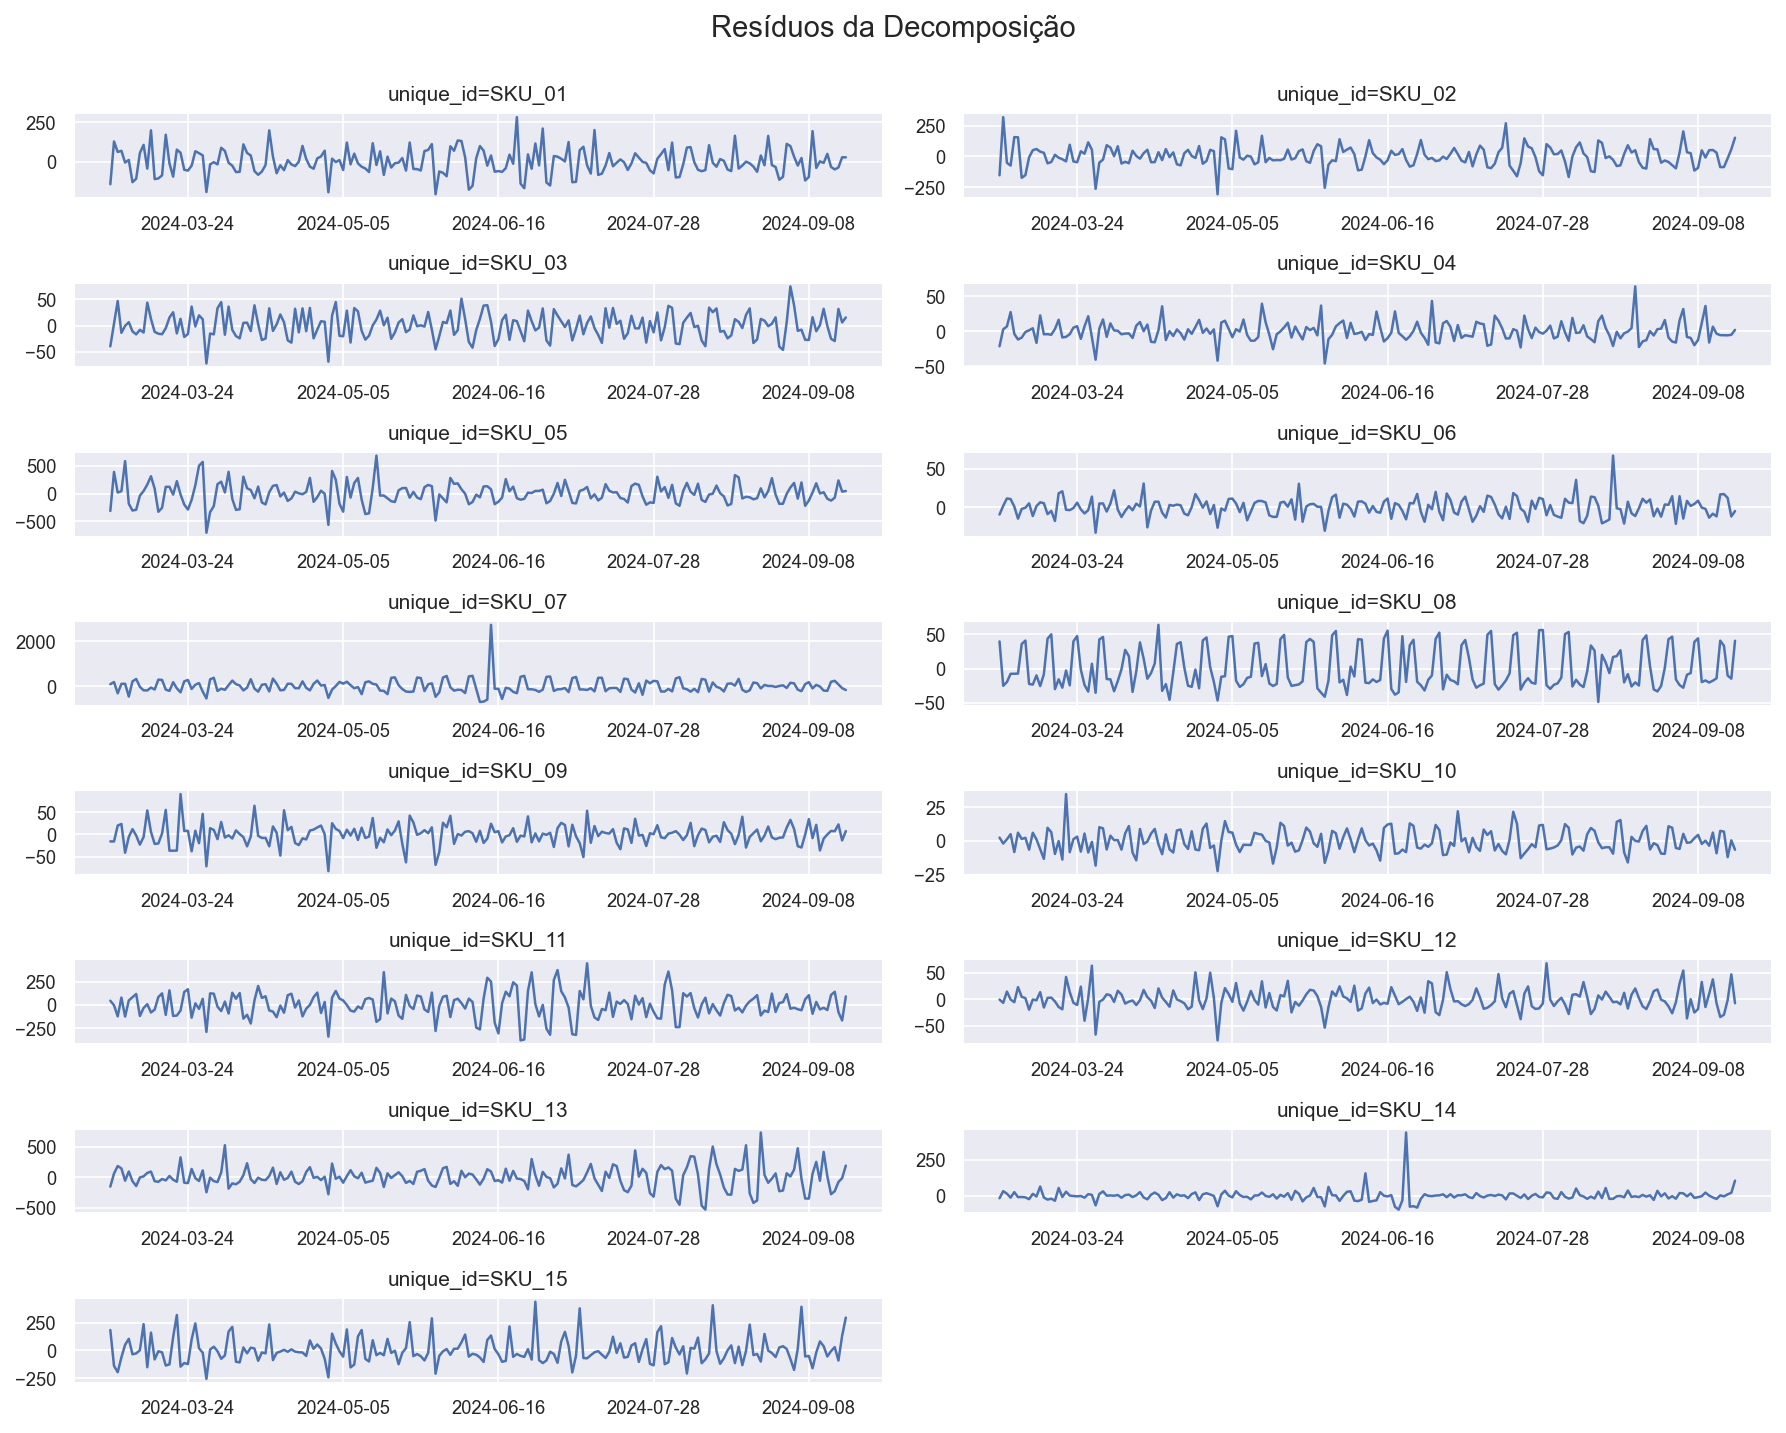

In [10]:
# plot dos resíduos da decomposição
fig5 = plot_time_series(
    decomposed_df,
    data_cols=['resid'],
    figsize=(12, 10),
    n_max=200,
    title='Resíduos da Decomposição'
)

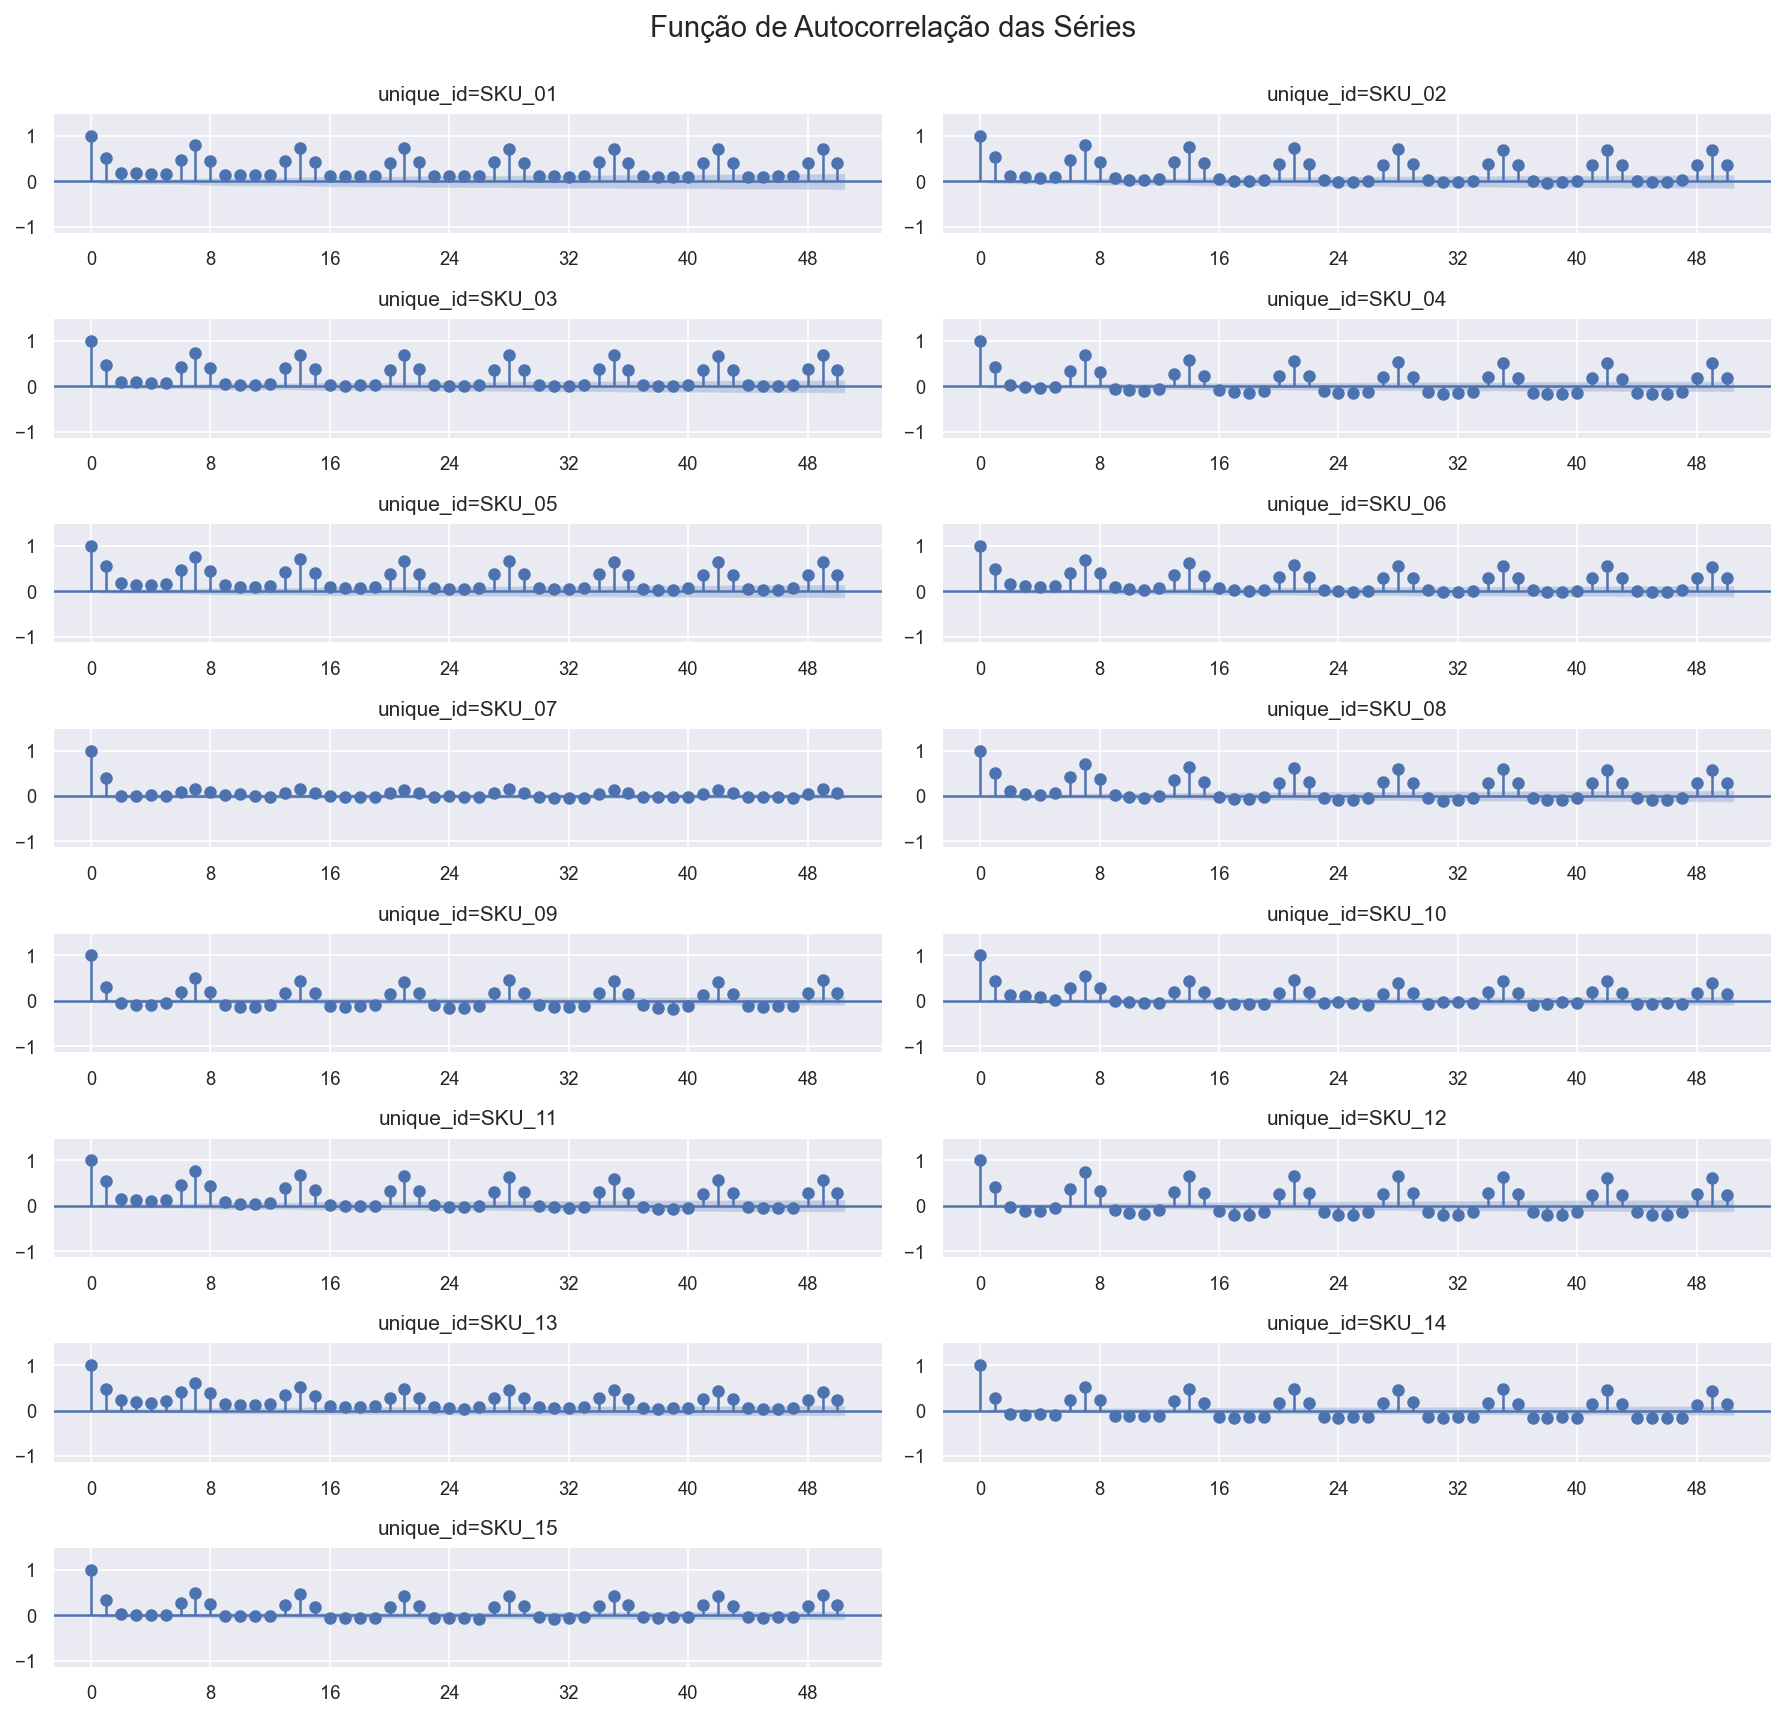

In [11]:
fig6 = plot_time_series_acf(
    df=df,
    target_col='y',
    max_lag=50,
    id_col='unique_id',
    title='Função de Autocorrelação das Séries',
)

In [12]:
# dividindo dados em treino e teste
train_df, test_df = ts_train_test_split(df=df, train_size=0.8, id_col='unique_id')

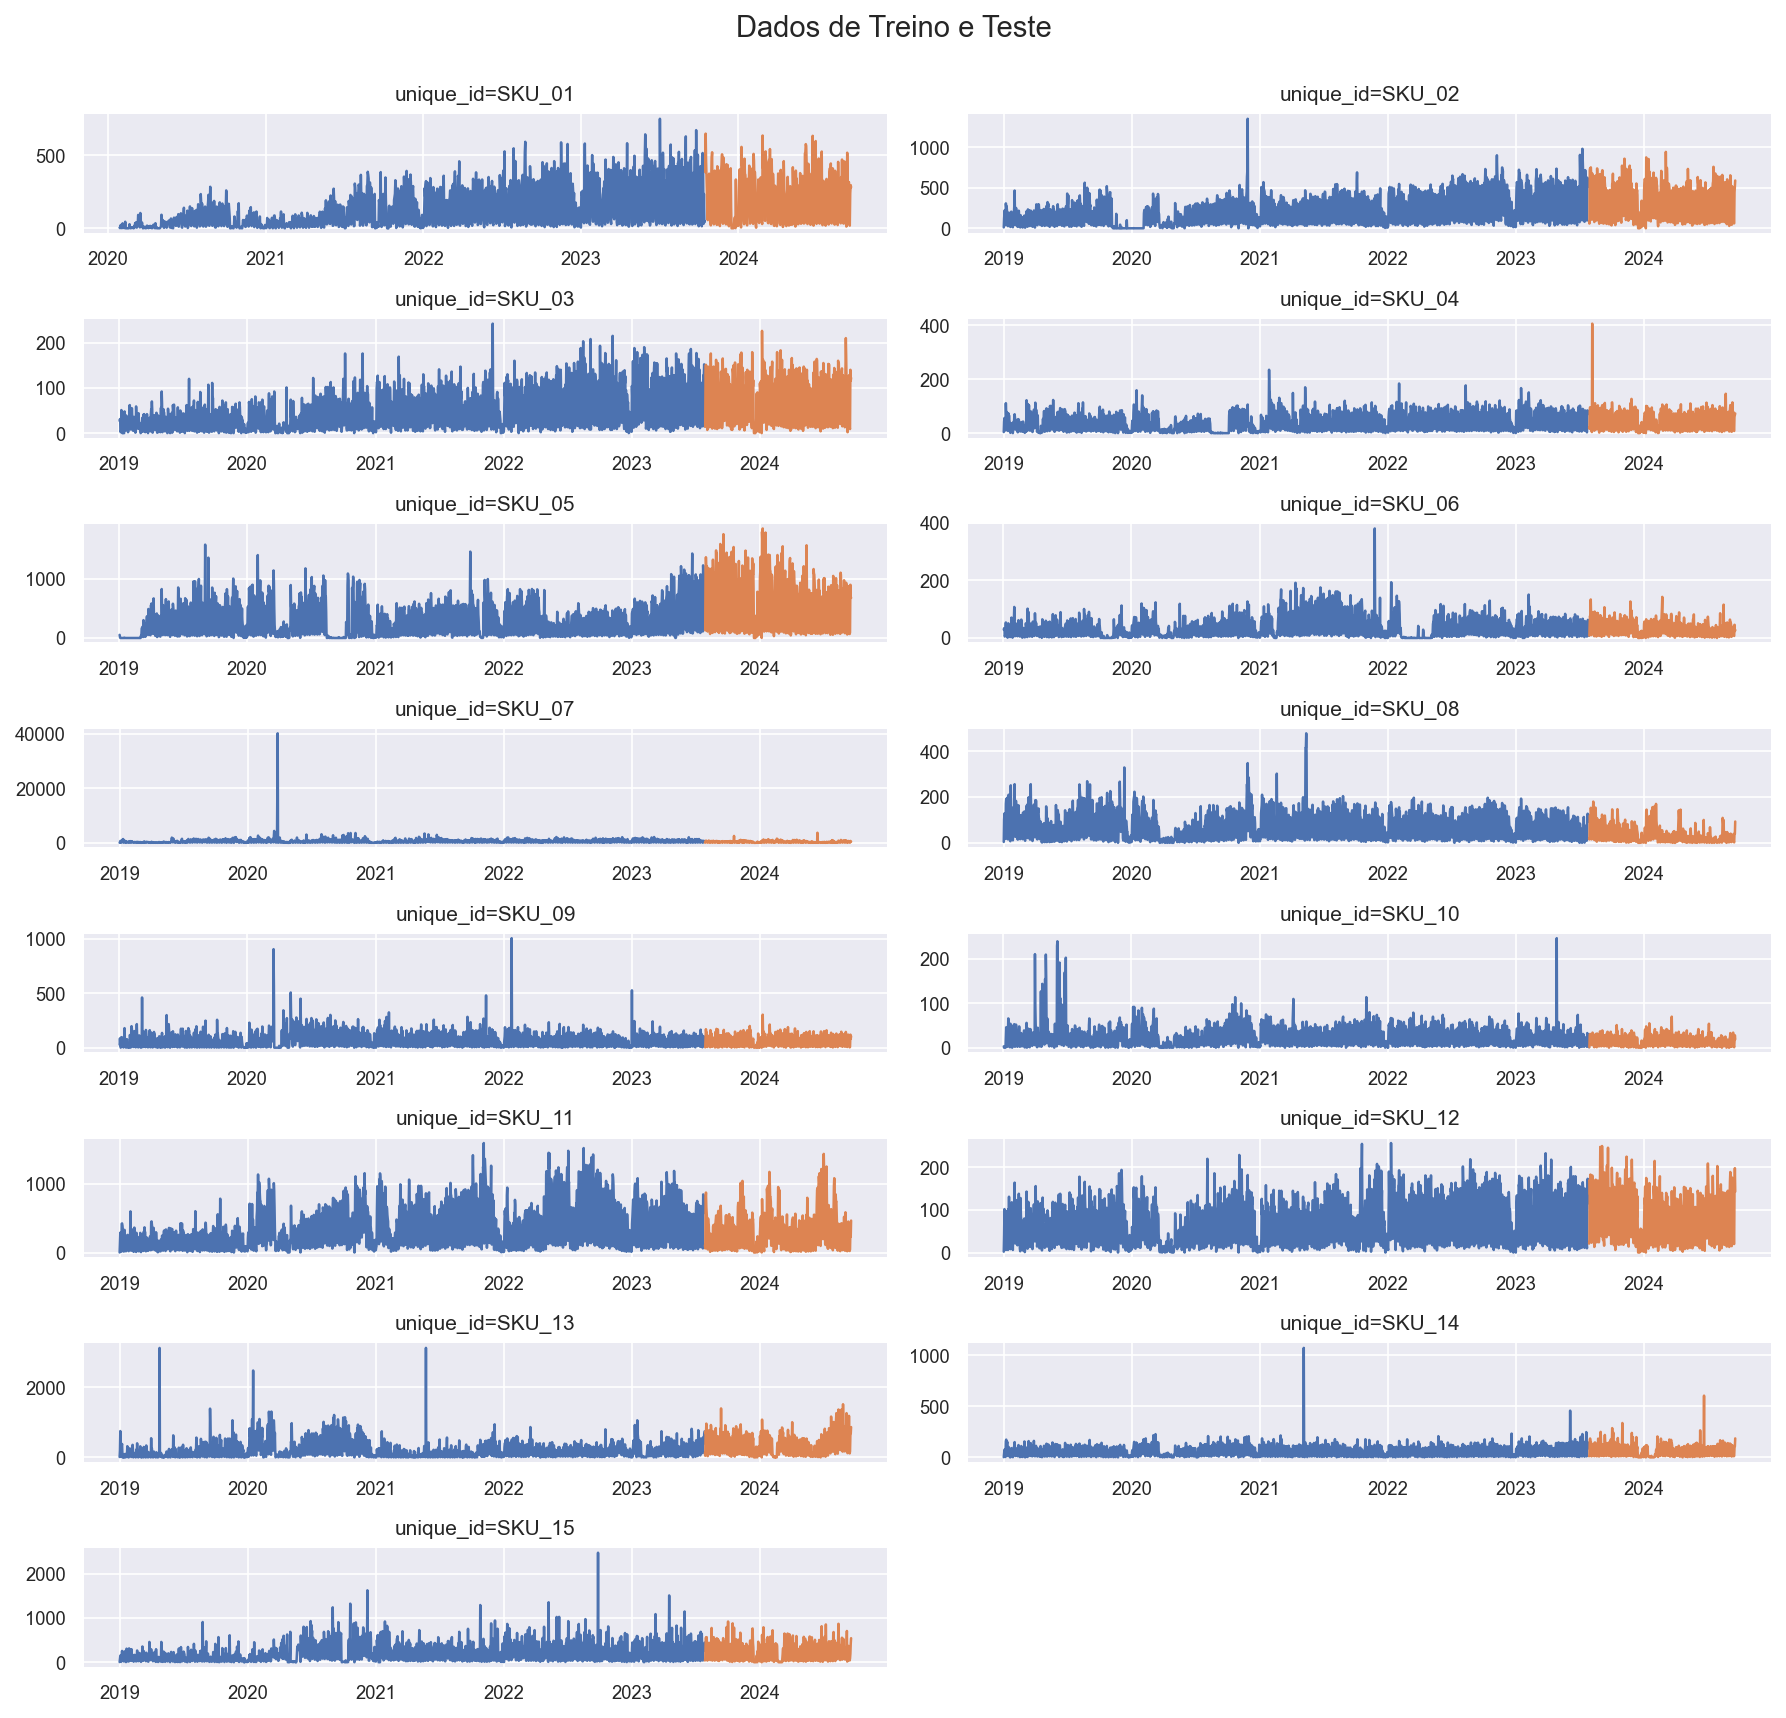

In [18]:
# visualizando split
fig7 = plot_time_series(
    df=train_df.merge(test_df, how='outer', on=['unique_id', 'ds'], suffixes=['_train','_test']),
    data_cols=['y_train', 'y_test'],
    title='Dados de Treino e Teste'
)

In [28]:
# salvando dados
train_df.to_csv("data/train_df.csv", index=False)
test_df.to_csv("data/test_df.csv", index=False)